In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pyro
import torch

import pyro.contrib.gp as gp
import pyro.distributions as dist

# Initialization

In [2]:
pyro.set_rng_seed(0)
pyro.clear_param_store()

## Data

In [3]:
def f(x):
    return torch.sin(20*x)+2*torch.cos(14*x)-2*torch.sin(6*x)

X = torch.tensor([-1.0, -0.5, 0.0, 0.5, 1])
y = f(X)# min = (0.233, -4.954)

# GP Model

In [4]:
kernel = gp.kernels.RBF(input_dim=1)
kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))
kernel.variance = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)))
gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(1e-4))
kernel._priors

OrderedDict([('lengthscale', LogNormal()), ('variance', LogNormal())])

## Training the model

In [5]:
nuts_kernel = pyro.infer.NUTS(gpr.model)
mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=1000, warmup_steps= 15, num_chains=4, disable_progbar = True)
mcmc.run()

var = mcmc.get_samples()["kernel.variance"]
ls = mcmc.get_samples()["kernel.lengthscale"]

                     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.lengthscale  0.305  0.179   0.030    0.613      0.006    0.004   
kernel.variance     4.562  4.883   0.842   10.769      0.160    0.113   

                    ess_bulk  ess_tail  r_hat  
kernel.lengthscale   961.960  1226.255  1.002  
kernel.variance     1301.219   966.933  1.004  


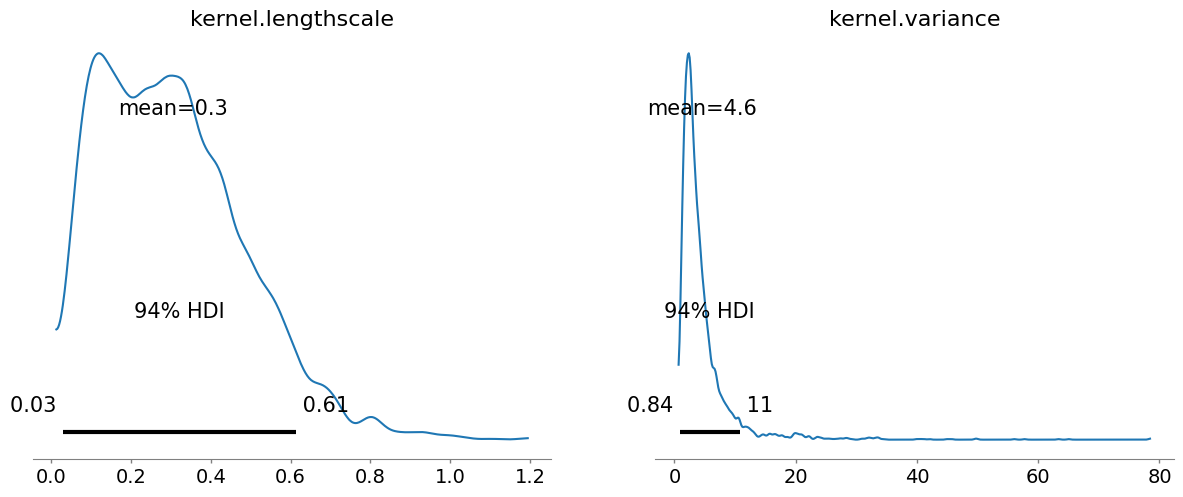

In [6]:
import arviz
data = arviz.from_pyro(mcmc, num_chains=4,log_likelihood=False)
summary = arviz.summary(data, round_to=3)
print(summary)
arviz.plot_posterior(data)
plt.show()

array([[<AxesSubplot: title={'center': 'kernel.lengthscale'}>,
        <AxesSubplot: title={'center': 'kernel.lengthscale'}>],
       [<AxesSubplot: title={'center': 'kernel.variance'}>,
        <AxesSubplot: title={'center': 'kernel.variance'}>]], dtype=object)

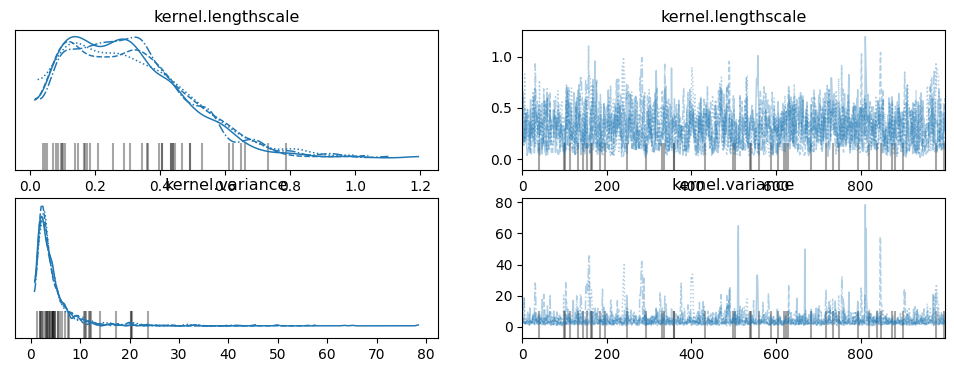

In [7]:
arviz.plot_trace(data)

In [8]:
mcmc.summary()


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.30      0.18      0.29      0.04      0.56    980.05      1.00
     kernel.variance      4.56      4.88      3.22      0.80      8.41    922.54      1.01

Number of divergences: 41


# Plot of parameters

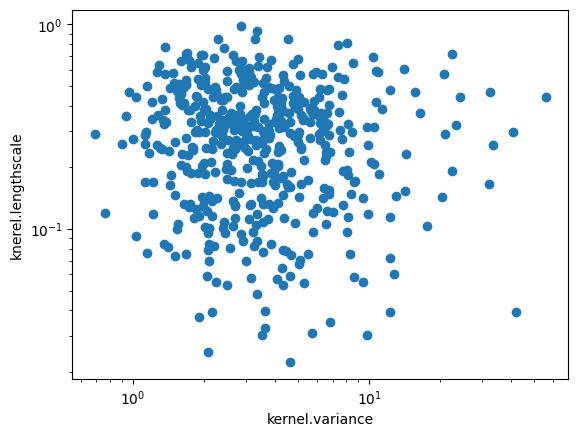

In [9]:
N = 500

var = mcmc.get_samples(num_samples=N, group_by_chain=False)["kernel.variance"]
ls = mcmc.get_samples(num_samples=N,group_by_chain=False)["kernel.lengthscale"]

plt.xscale("log")
plt.yscale("log")
plt.xlabel("kernel.variance")
plt.ylabel("knerel.lengthscale")
plt.scatter(var, ls)
plt.show()

In [10]:
mcmc.get_samples()["kernel.lengthscale"].shape[0]

4000

# Posterior predictive

In [11]:
def m(x):
    B = x.shape[0]
    var = mcmc.get_samples()["kernel.variance"]
    ls = mcmc.get_samples()["kernel.lengthscale"]
    N = var.shape[0]
    mu = torch.zeros((B,N))
    for i in range(N):
        pyro.clear_param_store()
        kern = gp.kernels.RBF(input_dim=1)
        kern.lengthscale = ls[i]
        kern.variance = var[i]
        gpr = gp.models.GPRegression(X, y, kern, noise=torch.tensor(1e-4))
        mu_i = gpr.forward(x)[0]
        mu[:,i] = mu_i
    m = torch.mean(mu, 1)
    C = mu - m.reshape(B,1)
    C = pow(C,2) + 1e-4
    v = torch.mean(C,1) 
    return m,v # mean and variance


In [12]:
# update kernel
#pyro.clear_param_store()
#kernel.lengthscale = torch.tensor(0.25) #ls.mean(0)
#kernel.variance = torch.tensor(7) #var.mean(0)
#gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(1e-4))

#f_loc, f_cov = gpr.forward(Xnew, full_cov=False, noiseless=True)

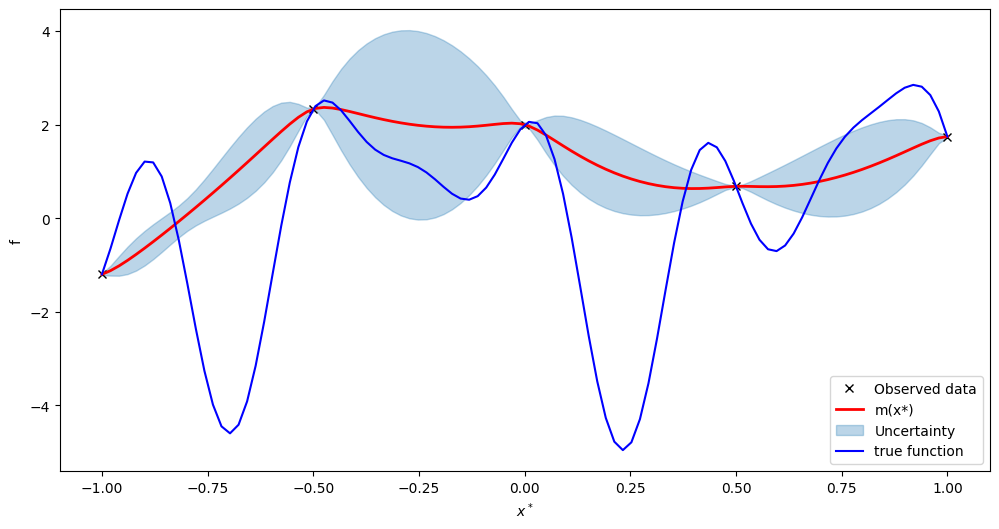

In [13]:
Xnew = torch.linspace(-1,1,100)
f_loc, f_cov = m(Xnew)

fig, ax = plt.subplots(figsize=(12, 6))
mean = f_loc.detach()
sd = f_cov.detach()

ax.plot(X.numpy(), y.numpy(), "kx", label = "Observed data")
ax.plot(Xnew.numpy(), mean, "r", lw=2, label="m(x*)")
ax.fill_between(
            Xnew.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * np.sqrt(sd)).numpy(),
            (mean + 2.0 * np.sqrt(sd)).numpy(),
            color="C0",
            alpha=0.3,
            label = "Uncertainty"
        )
ax.plot(Xnew.numpy(), f(Xnew).numpy(), "b", label = "true function")
ax.set_xlabel("$x^*$")
ax.set_ylabel("f")
ax.legend(loc=4)

# Bayesian Optimization

In [14]:
def f(x):
    return torch.sin(20*x)+2*torch.cos(14*x)-2*torch.sin(6*x)
X = torch.tensor([-1.0, -0.5, 0.0, 0.5, 1])
y = f(X)

T = 5
X_star = torch.linspace(-1,1, steps=200)

### After 5 iterations

In [15]:
for i in range(T):
    print(f'Iteration {i+1}')
    while True:
        try:
            pyro.clear_param_store()

            kernel = gp.kernels.RBF(input_dim=1)
            kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))
            kernel.variance = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)))
            gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(1e-4))

            nuts_kernel = pyro.infer.NUTS(gpr.model)
            mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=1, warmup_steps= 15, num_chains=1)
            mcmc.run()
            theta = mcmc.get_samples()

            kernel.lengthscale = theta["kernel.lengthscale"]
            kernel.variance = theta["kernel.variance"]
            gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(1e-4))

            f_loc, f_cov = gpr.forward(X_star, full_cov=True, noiseless=False)

            f_star = torch.distributions.MultivariateNormal(f_loc, f_cov).sample()
        except ValueError:
            continue
        break
    p = torch.argmin(f_star)
    X = torch.cat((X, X_star[p].reshape(1)))
    y = torch.cat((y, f(X_star[p].reshape(1))))

Iteration 1


Sample: 100%|██████████| 16/16 [00:00, 72.96it/s, step size=1.64e-01, acc. prob=0.986]


Iteration 2


Sample: 100%|██████████| 16/16 [00:00, 95.95it/s, step size=2.82e-01, acc. prob=0.999]


Iteration 3


Sample: 100%|██████████| 16/16 [00:00, 72.72it/s, step size=1.87e-01, acc. prob=0.998]


Iteration 4


Sample: 100%|██████████| 16/16 [00:00, 84.31it/s, step size=2.38e-01, acc. prob=0.913]


Iteration 5


Sample: 100%|██████████| 16/16 [00:00, 124.26it/s, step size=2.09e-01, acc. prob=0.714]


In [16]:
pyro.clear_param_store()
nuts_kernel.cleanup()
nuts_kernel.clear_cache()
kernel = gp.kernels.RBF(input_dim=1)
kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))
kernel.variance = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)))
gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(1e-4))
nuts_kernel = pyro.infer.NUTS(gpr.model)
mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=1000, warmup_steps= 15, num_chains=4, disable_progbar=True)
mcmc.run()
var = mcmc.get_samples()["kernel.variance"]
ls = mcmc.get_samples()["kernel.lengthscale"]

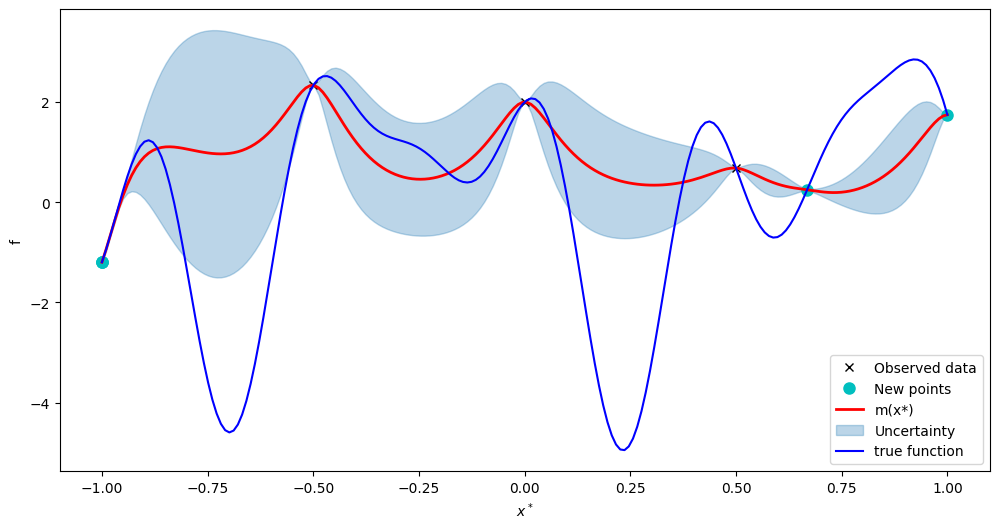

In [17]:
f_loc, f_cov = m(X_star)

fig, ax = plt.subplots(figsize=(12, 6))
mean = f_loc.detach()
sd = f_cov.detach()

ax.plot(X[0:4].numpy(), y[0:4].numpy(), "kx", label = "Observed data")
ax.plot(X[4:9].numpy(), y[4:9].numpy(), "co",markersize=8, label = "New points")
ax.plot(X_star.numpy(), mean, "r", lw=2, label="m(x*)")
ax.fill_between(
            X_star.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * np.sqrt(sd)).numpy(),
            (mean + 2.0 * np.sqrt(sd)).numpy(),
            color="C0",
            alpha=0.3,
            label = "Uncertainty"
        )
ax.plot(X_star.numpy(), f(X_star).numpy(), "b", label = "true function")
ax.set_xlabel("$x^*$")
ax.set_ylabel("f")
ax.legend(loc=4)

                     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.lengthscale  0.112  0.064   0.018    0.232      0.002    0.002   
kernel.variance     4.604  7.300   0.719    9.871      0.314    0.222   

                    ess_bulk  ess_tail  r_hat  
kernel.lengthscale  1239.791  1254.242  1.000  
kernel.variance     1118.351   984.242  1.002  


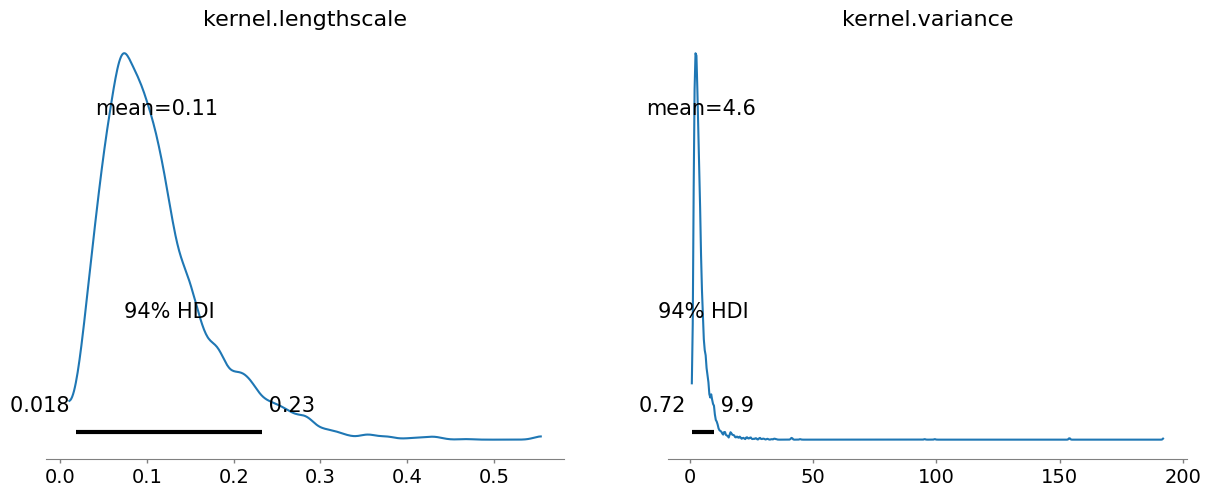

In [18]:
import arviz
data = arviz.from_pyro(mcmc, num_chains=4,log_likelihood=False)
summary = arviz.summary(data, round_to=3)
print(summary)
arviz.plot_posterior(data)
plt.show()

In [19]:
mcmc.summary()


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.11      0.06      0.10      0.03      0.21   1047.06      1.00
     kernel.variance      4.60      7.30      3.25      0.94      8.45    535.42      1.01

Number of divergences: 30


In [28]:
torch.linspace(1e-4,0.01,200)[1]-torch.linspace(1e-4,0.02,1000)[0]

tensor(4.9749e-05)

### After 10 iterations

In [20]:
for i in range(T):
    print(f'Iteration {5+i+1}')
    while True:
        try:
            pyro.clear_param_store()

            kernel = gp.kernels.RBF(input_dim=1)
            kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))
            kernel.variance = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)))
            gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(1e-4))

            nuts_kernel = pyro.infer.NUTS(gpr.model)
            mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=1, warmup_steps= 15, num_chains=1)
            mcmc.run()
            theta = mcmc.get_samples()

            kernel.lengthscale = theta["kernel.lengthscale"]
            kernel.variance = theta["kernel.variance"]
            gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(1e-4))

            f_loc, f_cov = gpr.forward(X_star, full_cov=True, noiseless=False)

            f_star = torch.distributions.MultivariateNormal(f_loc, f_cov).sample()
        except ValueError:
            continue
        break
    p = torch.argmin(f_star)
    X = torch.cat((X, X_star[p].reshape(1)))
    y = torch.cat((y, f(X_star[p].reshape(1))))
    
    nuts_kernel.cleanup()
    nuts_kernel.clear_cache()

Iteration 6


Sample: 100%|██████████| 16/16 [00:10,  1.46it/s, step size=2.72e-04, acc. prob=0.906]


Iteration 7


Sample: 100%|██████████| 16/16 [00:00, 66.60it/s, step size=1.26e-01, acc. prob=0.997]


Iteration 8


Sample: 100%|██████████| 16/16 [00:09,  1.61it/s, step size=1.94e-03, acc. prob=0.999]


Iteration 9


Sample: 100%|██████████| 16/16 [00:00, 120.20it/s, step size=4.84e-02, acc. prob=0.998]


Iteration 10


Sample: 100%|██████████| 16/16 [00:00, 103.22it/s, step size=1.84e-01, acc. prob=0.952]


In [21]:
pyro.clear_param_store()
nuts_kernel.cleanup()
nuts_kernel.clear_cache()
kernel = gp.kernels.RBF(input_dim=1)
kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))
kernel.variance = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)))
gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(1e-4))
nuts_kernel = pyro.infer.NUTS(gpr.model)
mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=1000, warmup_steps= 15, num_chains=4, disable_progbar=True)
mcmc.run()
var = mcmc.get_samples()["kernel.variance"]
ls = mcmc.get_samples()["kernel.lengthscale"]

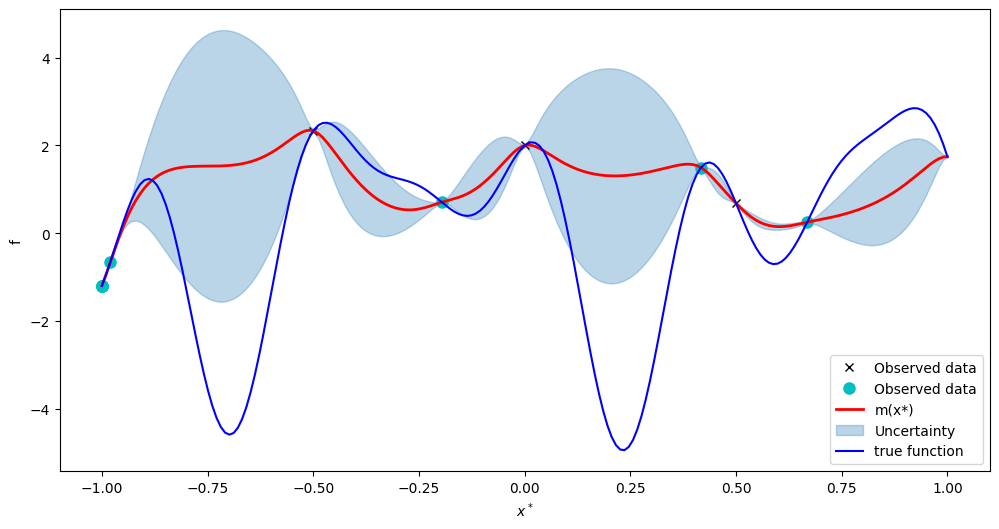

In [22]:
f_loc, f_cov = m(X_star)

fig, ax = plt.subplots(figsize=(12, 6))
mean = f_loc.detach()
sd = f_cov.detach()

ax.plot(X[0:4].numpy(), y[0:4].numpy(), "kx", label = "Observed data")
ax.plot(X[5:14].numpy(), y[5:14].numpy(), "co",markersize=8, label = "Observed data")
ax.plot(X_star.numpy(), mean, "r", lw=2, label="m(x*)")
ax.fill_between(
            X_star.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * np.sqrt(sd)).numpy(),
            (mean + 2.0 * np.sqrt(sd)).numpy(),
            color="C0",
            alpha=0.3,
            label = "Uncertainty"
        )
ax.plot(X_star.numpy(), f(X_star).numpy(), "b", label = "true function")
ax.set_xlabel("$x^*$")
ax.set_ylabel("f")
ax.legend(loc=4)

                     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.lengthscale  0.142  0.084   0.022    0.302      0.003    0.003   
kernel.variance     5.097  6.124   0.640   12.472      0.312    0.221   

                    ess_bulk  ess_tail  r_hat  
kernel.lengthscale   697.636   703.928  1.007  
kernel.variance      716.018   422.646  1.007  


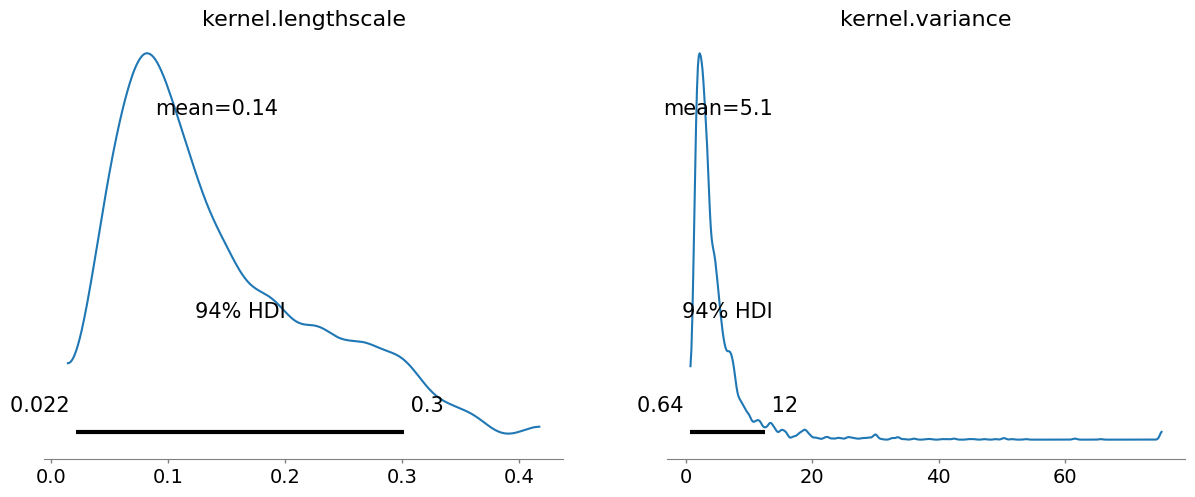

In [23]:
import arviz
data = arviz.from_pyro(mcmc, num_chains=4,log_likelihood=False)
summary = arviz.summary(data, round_to=3)
print(summary)
arviz.plot_posterior(data)
plt.show()

In [24]:
mcmc.summary()


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.14      0.08      0.12      0.02      0.28    624.15      1.01
     kernel.variance      5.10      6.12      3.40      0.79      9.33    382.26      1.01

Number of divergences: 117


# Multiple runs

In [4]:
T = 10
K = 10
X_star = torch.linspace(-1,1, steps=200)

min_y = torch.zeros(K)
argmin_y = torch.zeros(K)

for k in range(K):
    print(f'Epoch {k+1}')
    X = torch.tensor([-1.0, -0.5, 0.0, 0.5, 1])
    y = f(X)
    for i in range(T):
        while True:
            try:
                pyro.clear_param_store()

                kernel = gp.kernels.RBF(input_dim=1)
                kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))
                kernel.variance = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)))
                gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(1e-4))

                nuts_kernel = pyro.infer.NUTS(gpr.model)
                mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=1, warmup_steps= 15, num_chains=1, disable_progbar=True)
                mcmc.run()
                theta = mcmc.get_samples()

                kernel.lengthscale = theta["kernel.lengthscale"]
                kernel.variance = theta["kernel.variance"]
                gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(1e-4))

                f_loc, f_cov = gpr.forward(X_star, full_cov=True, noiseless=False)

                f_star = torch.distributions.MultivariateNormal(f_loc, f_cov).sample()
            except ValueError:
                continue
            break
        p = torch.argmin(f_star)
        X = torch.cat((X, X_star[p].reshape(1)))
        y = torch.cat((y, f(X_star[p].reshape(1))))
        
    argmin_y[k] = X[torch.argmin(y)]
    min_y[k] = torch.min(y)

Epoch 1


KeyboardInterrupt: 

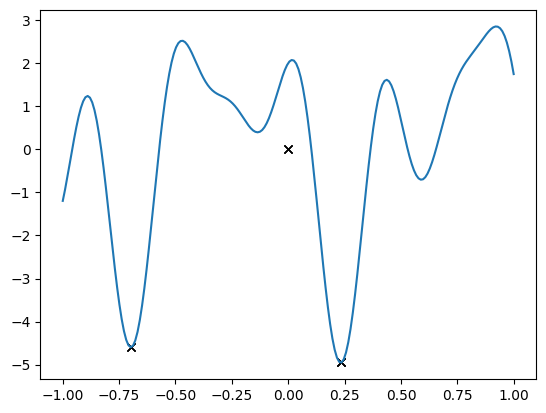

In [77]:
plt.plot(argmin_y, min_y, "kx")
plt.plot(X_star.numpy(), f(X_star).numpy())

# Combining kernels

In [101]:
pyro.clear_param_store()
linear = gp.kernels.Linear(input_dim=1)
periodic = gp.kernels.Periodic(input_dim=1)
rbf = gp.kernels.RBF(input_dim=1)

rbf.lengthscale = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))
rbf.variance = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)))
periodic.period = pyro.nn.PyroSample(dist.Uniform(torch.tensor(0.5), torch.tensor(1.5)))

k1 = gp.kernels.Product(kern0=rbf, kern1=periodic)

kernel = gp.kernels.Sum(linear, k1)

gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(1e-4))

In [102]:
nuts_kernel = pyro.infer.NUTS(gpr.model)
mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=300, warmup_steps= 100, num_chains=4, disable_progbar = False)
mcmc.run()

Warmup [1]:   0%|          | 0/400 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/400 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/400 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/400 [00:00, ?it/s]

                                 mean     sd  hdi_3%  hdi_97%  mcse_mean  \
kernel.kern1.kern0.lengthscale  0.587  0.605   0.017    1.470      0.026   
kernel.kern1.kern0.variance     4.009  4.125   0.642   10.093      0.228   
kernel.kern1.kern1.period       0.988  0.294   0.513    1.430      0.014   

                                mcse_sd  ess_bulk  ess_tail  r_hat  
kernel.kern1.kern0.lengthscale    0.018   591.606   623.320  1.002  
kernel.kern1.kern0.variance       0.162   694.994   381.434  1.020  
kernel.kern1.kern1.period         0.010   435.763   522.690  1.009  


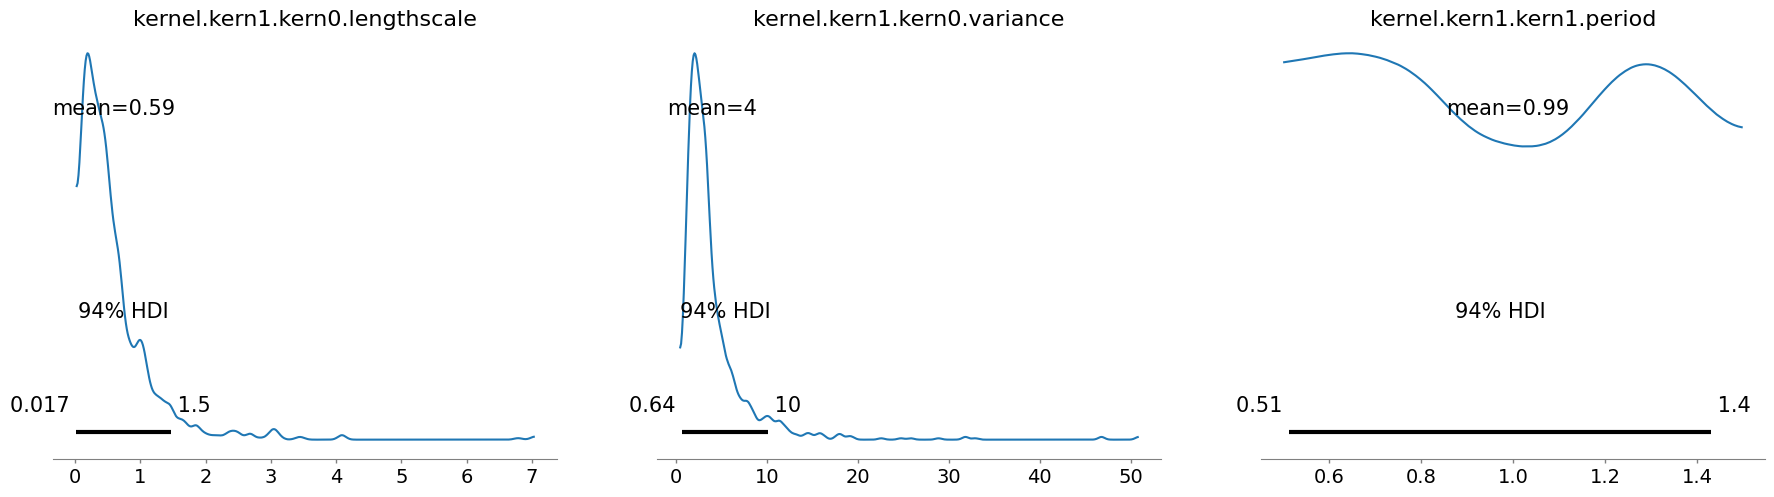

In [103]:
import arviz
data = arviz.from_pyro(mcmc, num_chains=4,log_likelihood=False)
summary = arviz.summary(data, round_to=3)
print(summary)
arviz.plot_posterior(data)
plt.show()

In [4]:
T = 10
K = 20
X_star = torch.linspace(-1,1, steps=200)

min_y = torch.zeros(K)
argmin_y = torch.zeros(K)

for k in range(K):
    print(f'Epoch {k+1}')
    X = torch.tensor([-1.0, -0.5, 0.0, 0.5, 1])
    y = f(X)
    for i in range(10):
        while True:
            try:
                pyro.clear_param_store()
                linear = gp.kernels.Linear(input_dim=1)
                periodic = gp.kernels.Periodic(input_dim=1)
                rbf = gp.kernels.RBF(input_dim=1)

                rbf.lengthscale = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))
                rbf.variance = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)))
                periodic.period = pyro.nn.PyroSample(dist.Uniform(torch.tensor(0.5), torch.tensor(1.5)))

                k1 = gp.kernels.Product(kern0=rbf, kern1=periodic)

                kernel = gp.kernels.Sum(linear, k1)

                gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(1e-4))

                nuts_kernel = pyro.infer.NUTS(gpr.model)
                mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=1, warmup_steps= 200, num_chains=1, disable_progbar=True)
                mcmc.run()
                theta = mcmc.get_samples()
                len, var, per = mcmc.get_samples().keys()

                rbf.lengthscale  = theta[var]
                rbf.variance = theta[var]
                periodic.period = theta[per]
                k1 = gp.kernels.Product(kern0=rbf, kern1=periodic)
                kernel = gp.kernels.Sum(linear, k1)
                gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(1e-4))

                f_loc, f_cov = gpr.forward(X_star, full_cov=True, noiseless=False)

                f_star = torch.distributions.MultivariateNormal(f_loc, f_cov).sample()
            except ValueError:
                continue
            break
        p = torch.argmin(f_star)
        X = torch.cat((X, X_star[p].reshape(1)))
        y = torch.cat((y, f(X_star[p].reshape(1))))
        
    argmin_y[k] = X[torch.argmin(y)]
    min_y[k] = torch.min(y)

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20


In [5]:
min_y

tensor([-1.1983, -4.5962, -4.9492, -4.9492, -4.5962, -4.9492, -3.9668, -1.1983,
        -4.9492, -1.1983, -3.2097, -4.5586, -4.5962, -1.1983, -4.4816, -4.9492,
        -4.9492, -4.9358, -4.5962, -4.9492])

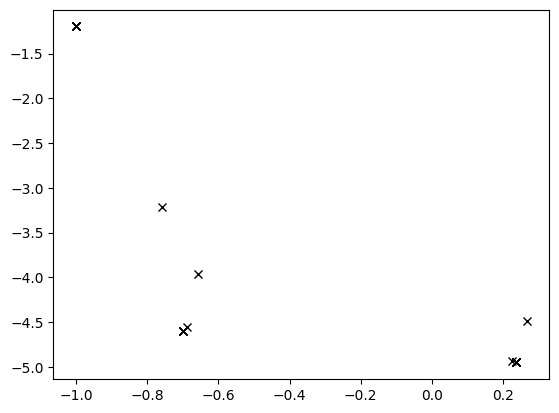

In [6]:
plt.plot(argmin_y, min_y, "kx")

In [8]:
argmin_y

tensor([-1.0000, -0.6985,  0.2362,  0.2362, -0.6985,  0.2362, -0.6583, -1.0000,
         0.2362, -1.0000, -0.7588, -0.6884, -0.6985, -1.0000,  0.2663,  0.2362,
         0.2362,  0.2261, -0.6985,  0.2362])